# Generating 3D models with generative adversarial networks



## Imports

In [7]:
!wget "https://raw.githubusercontent.com/pclausen/binvox-rw-py/public/binvox_rw.py" -O "binvox_rw.py"
!pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
!pip install aiohttp nest-asyncio

--2022-06-17 06:49:39--  https://raw.githubusercontent.com/pclausen/binvox-rw-py/public/binvox_rw.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9440 (9.2K) [text/plain]
Saving to: ‘binvox_rw.py’

binvox_rw.py        100%[===================>]   9.22K  --.-KB/s    in 0s      

2022-06-17 06:49:39 (70.5 MB/s) - ‘binvox_rw.py’ saved [9440/9440]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-k8gx79z0
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-k8gx79z0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

import binvox_rw
import requests
import aiohttp
import asyncio
from io import BytesIO

from sys import version_info
from tqdm.notebook import tqdm as nb_tqdm
import ipywidgets as widgets
from torchviz import make_dot

In [9]:
class tqdm_asyncio(nb_tqdm):
    """
    Asynchronous-friendly version of tqdm (Python 3.6+).
    """
    def __init__(self, iterable=None, *args, **kwargs):
        super(tqdm_asyncio, self).__init__(iterable, *args, **kwargs)
        self.iterable_awaitable = False
        if iterable is not None:
            if hasattr(iterable, "__anext__"):
                self.iterable_next = iterable.__anext__
                self.iterable_awaitable = True
            elif hasattr(iterable, "__next__"):
                self.iterable_next = iterable.__next__
            else:
                self.iterable_iterator = iter(iterable)
                self.iterable_next = self.iterable_iterator.__next__

    def __aiter__(self):
        return self

    async def __anext__(self):
        try:
            if self.iterable_awaitable:
                res = await self.iterable_next()
            else:
                res = self.iterable_next()
            self.update()
            return res
        except StopIteration:
            self.close()
            raise StopAsyncIteration
        except BaseException:
            self.close()
            raise

    def send(self, *args, **kwargs):
        return self.iterable.send(*args, **kwargs)

    @classmethod
    def as_completed(cls, fs, *, loop=None, timeout=None, total=None, **tqdm_kwargs):
        """
        Wrapper for `asyncio.as_completed`.
        """
        if total is None:
            total = len(fs)
        kwargs = {}
        if version_info[:2] < (3, 10):
            kwargs['loop'] = loop
        yield from cls(asyncio.as_completed(fs, timeout=timeout, **kwargs),
                       total=total, **tqdm_kwargs)

    @classmethod
    async def gather(cls, *fs, loop=None, timeout=None, total=None, **tqdm_kwargs):
        """
        Wrapper for `asyncio.gather`.
        """
        async def wrap_awaitable(i, f):
            return i, await f

        ifs = [wrap_awaitable(i, f) for i, f in enumerate(fs)]
        res = [await f for f in cls.as_completed(ifs, loop=loop, timeout=timeout,
                                                 total=total, **tqdm_kwargs)]
        return [i for _, i in sorted(res)]

In [10]:
import nest_asyncio
nest_asyncio.apply()

In [11]:
def make_query(start, rows=160):
  return {
      "q": f"wnhypersynsets:{dataset} AND source:(3dw OR yobi3d) AND isSingleCleanObject:true AND isAligned:true AND updated:*",
      "wt": "json",
      "sort": " hasModel desc, popularity desc",
      "start": start,
      "rows": rows,
      "fq": "  +hasModel:true -modelSize:[10000000 TO * ]",
      "fl": ''
  }

In [12]:
try:
  os.mkdir("output")
except FileExistsError:
  pass
def save_binvox(array, name):
  global object_dims
  model = binvox_rw.Voxels(array, list(object_shape), [0., 0., 0.], 1.0, 'xzy')
  binvox_rw.write(model, open(f"output/{name}.binvox", "w+b"))

## Config

In [13]:
dataset = "03001627" # Chairs
download_batch_size = 256
dataset_max_size = 32*16

object_shape = (128, 128, 128)
validate_percent = 0.07
batch_size = 32

latent_size = 128

In [14]:
dropdown = widgets.Dropdown(
    options=[(x['text'], x['metadata']['name']) for x in requests.get("https://shapenet.org/resources/data/shapenetcore.taxonomy.json").json()]
)
def on_change(x):
    global dataset
    dataset = x['new']
dropdown.observe(on_change, 'value')
dropdown

Dropdown(options=(('airplane,aeroplane,plane(11,4045)', '02691156'), ('ashcan,trash can,garbage can,wastebin,a…

## Fetch objects 

In [15]:
async def fetch_single(entry, i, session, objects):
  if i >= dataset_max_size:
    return
  global dataset, object_shape
  m_id = entry['id']
  r = await session.get(f"https://shapenet.org/shapenet/obj-zip/ShapeNetCore.v1/{dataset}/{m_id}/model.binvox")
  raw = BytesIO(await r.read())
  model = binvox_rw.read_as_3d_array(raw)
  data = model.data
  if data.shape != object_shape:
    print(f"[{m_id}] W: Wrong shape: {data.shape}")
    return
  data = data.astype(np.float32)
  objects[i] = data

objects = None
async def fetch():
  global dataset, download_batch_size, dataset_max_size, objects
  if os.path.isfile("dataset.npy"):
    objects = np.memmap("dataset.npy", dtype='float32', mode='r+', shape=tuple([dataset_max_size]+list(object_shape)))
    print("dataset.npy not empty. using previous value. Delete file to restart")
  else:
    objects = np.memmap("dataset.npy", dtype='float32', mode='w+', shape=tuple([dataset_max_size]+list(object_shape)))
    batch = 0
    async with aiohttp.ClientSession() as session:
      while True:
        if batch*download_batch_size >= dataset_max_size:
          break
        print(f"Batch {batch}")
        progressbar = tqdm_asyncio(total=download_batch_size, position=0, leave=True)
        r = await session.post("https://shapenet.org/solr/models3d/select", data=make_query(batch*download_batch_size, download_batch_size))
        if r.status != 200:
          break
        entries = (await r.json()).get('response', {}).get('docs', [])
        if len(entries) < 1:
          break
        routines = [fetch_single(
            entry, batch*download_batch_size + i, session, objects
        ) for i, entry in enumerate(entries)]
        res = await progressbar.gather(*routines)
        errors = [x for x in res if isinstance(x, BaseException)]
        if len(errors) > 0:
          for error in errors:
            print(error)
          break
        batch += 1
  print(f"Fetched: {len(objects)} objects.")

loop = asyncio.get_event_loop()
loop.run_until_complete(fetch())

Batch 0


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Batch 1


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Batch 2


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Batch 3


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Batch 4


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Fetched: 1280 objects.


## Init PyTorch 

In [16]:
def normalize(data):
    data = data.unsqueeze(dim=1)
    return data

In [17]:
def denormalize(data):
  data = data.squeeze().squeeze()
  return data

In [18]:
def latent_transform(data):
    data = data.reshape((latent_size, 1, 1, 1))
    data = data.unsqueeze(dim=0)
    return data

In [19]:
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

val_size = int(len(objects)*validate_percent)
train_size = len(objects) - val_size


train_ds, val_ds = random_split(objects, [train_size, val_size])


train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = DeviceDataLoader(train_loader, device)

## Create models

In [23]:
discriminator = nn.Sequential(
    nn.Conv3d(1, 64, kernel_size=4, stride=4, padding=1, bias=False),
    nn.BatchNorm3d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm3d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm3d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm3d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

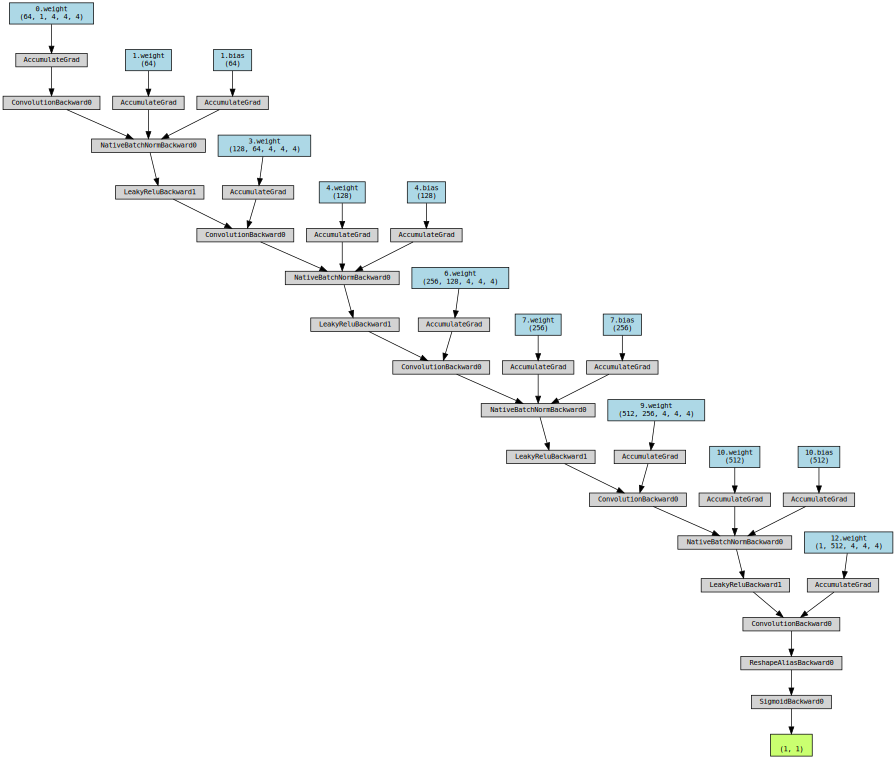

In [24]:
make_dot(discriminator(torch.zeros([1, 1, 128, 128, 128])), params=dict(discriminator.named_parameters()))

In [25]:
discriminator = to_device(discriminator, device)

In [26]:
class GeneratorModel(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Sequential(
          nn.ConvTranspose3d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
          nn.BatchNorm3d(512),
          nn.ReLU(True)
      )

      self.conv2 = nn.Sequential(
          nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm3d(256),
          nn.ReLU(True)
      )

      self.conv3 = nn.Sequential(
          nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm3d(128),
          nn.ReLU(True)
      )

      self.conv4 = nn.Sequential(
          nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm3d(64),
          nn.ReLU(True)
      )

      self.conv5 = nn.ConvTranspose3d(64, 1, kernel_size=4, stride=4, padding=0, bias=False)

      self.tan = nn.Tanh()
      self.sig = nn.Hardsigmoid(True)
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.tan(out)
        return out

generator = GeneratorModel()

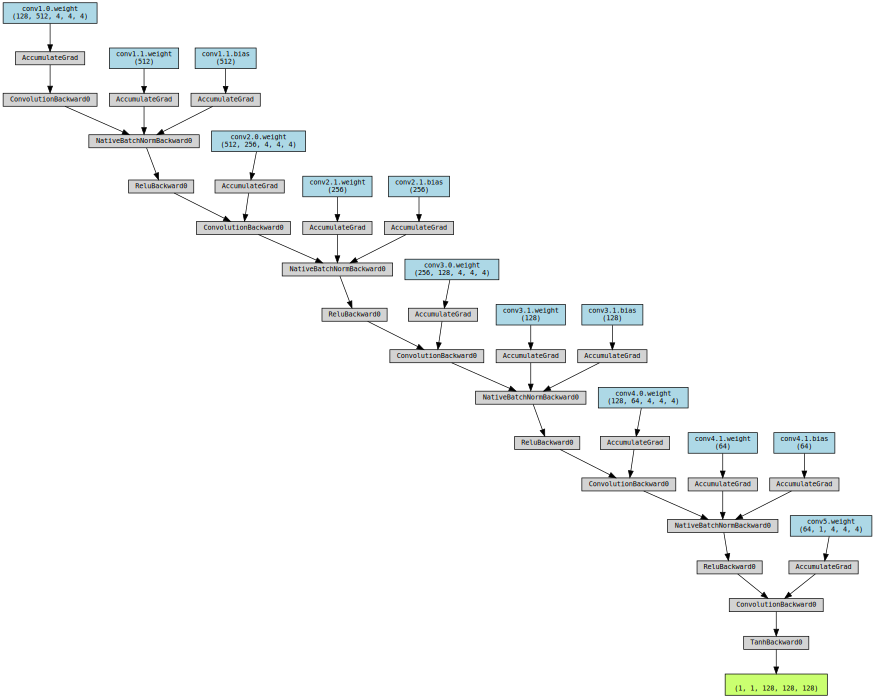

In [27]:
make_dot(generator(latent_transform(torch.zeros(latent_size))), params=dict(generator.named_parameters()))

In [28]:
generator = to_device(generator, device)

## Train

In [29]:
def train_discriminator(real_objects, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(normalize(real_objects))
    real_targets = torch.ones(real_objects.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, 1, device=device)
    fake_objects = generator(latent)

    fake_targets = torch.zeros(fake_objects.size(0), 1, device=device)
    fake_preds = discriminator(fake_objects)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [30]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device).unsqueeze(dim=2)
    fake_objects = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_objects)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [31]:
@torch.no_grad()
def save_sample(index, latent_tensors):
    fake_object = denormalize(generator(latent_tensors)[0])
    fake_object = fake_object.cpu().numpy()
    fake_object = fake_object >= 0.5
    save_binvox(fake_object, index)
    

In [32]:
fixed_latent = torch.randn(1, latent_size, 1, 1, 1, device=device)

In [33]:
save_sample(0, fixed_latent)

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_objects in nb_tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_objects, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_sample(epoch+start_idx, fixed_latent)
    
    return losses_g, losses_d, real_scores, fake_scores

In [35]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/25], loss_g: 4.3303, loss_d: 0.7573, real_score: 0.8388, fake_score: 0.3883


  0%|          | 0/38 [00:00<?, ?it/s]

## Display stats

You can use [voxelizer](https://drububu.com/miscellaneous/voxelizer/?out=objs) to view `.binvox` and convert it to more popular 3d object formats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')
plt.show()